In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 50
width, height = 48, 48

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Aura/fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
pixels = data['pixels'].tolist() # 1

faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # 2
    face = np.asarray(face).reshape(width, height) # 3
    
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) # 6

emotions = pd.get_dummies(data['emotion']).values # 7

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [ ]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

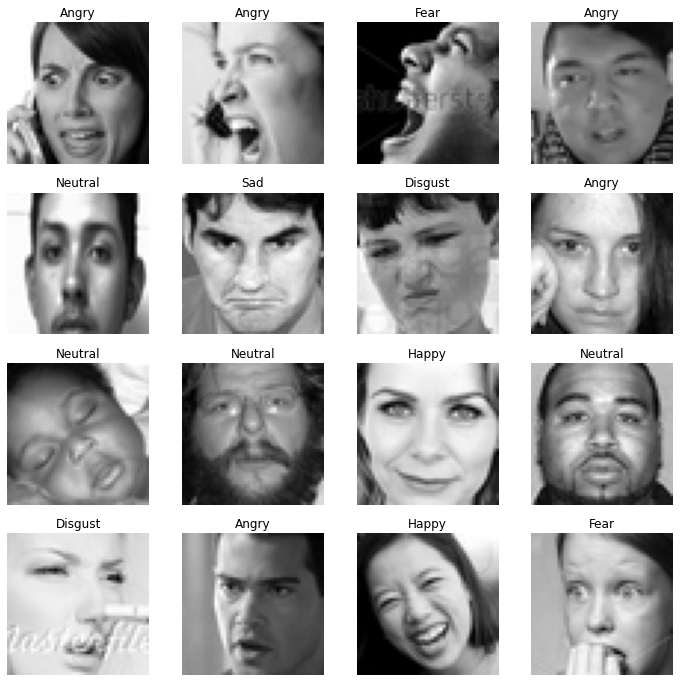

In [ ]:
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()


In [ ]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

In [ ]:
tensorboard = TensorBoard(log_dir='./logs')

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [ ]:
checkpointer = ModelCheckpoint("/content/drive/MyDrive/Aura/models/model100epochsWithGPU_new.h5", monitor='val_loss', verbose=1, save_best_only=True)

Epoch 1/50
455/455 [==============================] - 70s 49ms/step - loss: 2.2893 - accuracy: 0.2012 - val_loss: 1.8314 - val_accuracy: 0.2274

Epoch 00001: val_loss improved from inf to 1.83137, saving model to /content/drive/MyDrive/Aura/models/model100epochsWithGPU_new.h5
Epoch 2/50
455/455 [==============================] - 20s 44ms/step - loss: 1.8430 - accuracy: 0.2453 - val_loss: 1.8126 - val_accuracy: 0.2471

Epoch 00002: val_loss improved from 1.83137 to 1.81260, saving model to /content/drive/MyDrive/Aura/models/model100epochsWithGPU_new.h5
Epoch 3/50
455/455 [==============================] - 20s 43ms/step - loss: 1.8168 - accuracy: 0.2562 - val_loss: 1.8954 - val_accuracy: 0.2463

Epoch 00003: val_loss did not improve from 1.81260
Epoch 4/50
455/455 [==============================] - 20s 45ms/step - loss: 1.7216 - accuracy: 0.3084 - val_loss: 1.5980 - val_accuracy: 0.3664

Epoch 00004: val_loss improved from 1.81260 to 1.59795, saving model to /content/drive/MyDrive/Aura/m

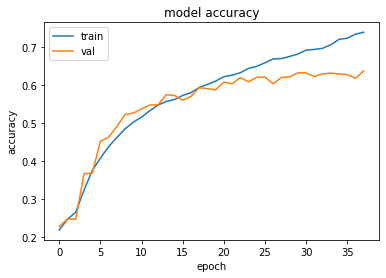

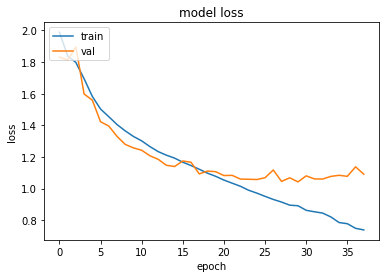

In [ ]:
history=model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print('\n\n')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

57/57 [==============================] - 1s 14ms/step - loss: 1.0911 - accuracy: 0.6369
Loss: 1.0910637378692627
Accuracy: 0.6369462013244629


In [ ]:
model = load_model("/content/drive/MyDrive/Aura/models/model100epochsWithGPU_new.h5")

In [ ]:
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

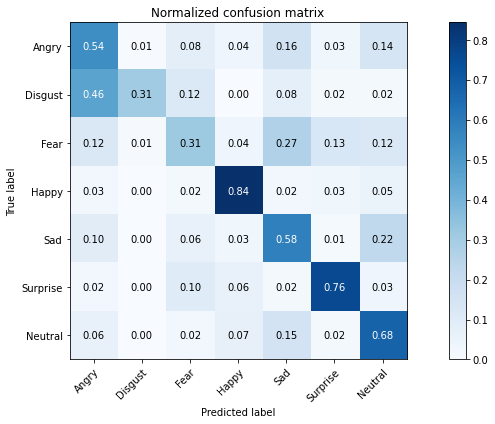

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

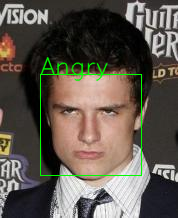

In [ ]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

model = load_model("/content/drive/MyDrive/Aura/models/model100epochsWithGPU.h5")

cap = cv2.VideoCapture(0)


    # ret, frame = cap.read()
frame = cv2.imread("/content/drive/MyDrive/Aura/000091.jpg")

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Aura/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = model.predict(cropped_img)
    cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
with open('/content/drive/MyDrive/Aura/Moodoutput.txt', 'w') as f:
  f.write(emotion_dict[int(np.argmax(prediction))])
cv2_imshow(frame)


# cap.release()
# cv2.destroyAllWindows()